# Results

| **avg accuracy**    | logistic | xgboost |
|---------------------|----------|---------|
| per file            | 0.66     | 0.57    |
| train all, test one | 0.58     | 0.54    |
| train one, test all | 0.53     | 0.58    |

In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from util.rank_metrics import mean_average_precision

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
xgb.set_config(verbosity=1)

#
from util.Util import plot_accuracies, read_csv
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier

file_names = ['Computer vision','Consulting','Fintech','Fish processing equipment','Healthcare','House builders','Industrial vertical investor','Innovative','IoT','IT freelance','M&A advisors','Manufacturers','Online games','Payments tech','PE fund','Procurement software','Resource-efficiency','SaaS','Sustainability','Wind turbine tech']

In [2]:
# Read GLOVE embeddings from file
glove_df = read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Reading CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:22, 86221.18it/s]


In [61]:
# Read the cleaned dataframe
full_df = read_csv('data/processed_data/cleaned_v1.csv')

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description_no_stopwords'
vectorizer = TfidfVectorizer(max_features=500)
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col, verbose=False)

* Reading CSV from path: data/processed_data/cleaned_v1.csv. Size: (60122, 7)


# Classification

## Per file: Train on labelled, test on initials 

#### Logistic regression

In [8]:
accuracies = {}

for file_name in tqdm(file_names):
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X_train, y_train, X_test, y_test = dfc.get_feature_vectors(split=True)

    clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)
    accuracies[file_name] = clf.score(X_test,y_test)
    

100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


In [9]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.7406932773109244
---
{'Computer vision': 1.0, 'Consulting': 0.8, 'Fintech': 0.23529411764705882, 'Fish processing equipment': 1.0, 'Healthcare': 1.0, 'House builders': 0.75, 'Industrial vertical investor': 1.0, 'Innovative': 0.3333333333333333, 'IoT': 0.6, 'IT freelance': 0.625, 'M&A advisors': 1.0, 'Manufacturers': 0.0, 'Online games': 1.0, 'Payments tech': 1.0, 'PE fund': 0.875, 'Procurement software': 0.5, 'Resource-efficiency': 1.0, 'SaaS': 0.42857142857142855, 'Sustainability': 0.6666666666666666, 'Wind turbine tech': 1.0}


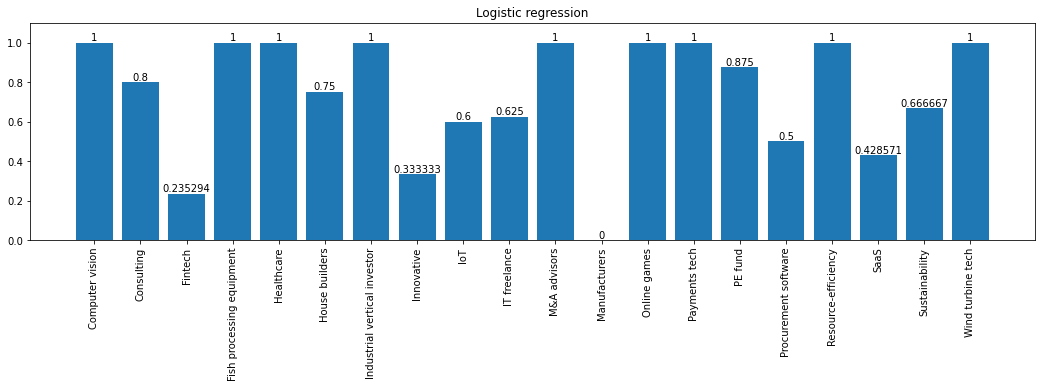

In [10]:
_, _ = plot_accuracies(accuracies, "Logistic regression")
plt.show()

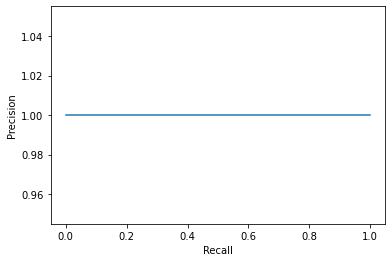

In [20]:
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

#### XGBoost

In [29]:
accuracies = {}

for file_name in tqdm(file_names):
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X_train, y_train, X_test, y_test = dfc.get_feature_vectors(split=True)

    xg_reg = xgb.XGBRegressor()
    xg_reg.fit(X_train, y_train)
    
    accuracies[file_name] = mean_squared_error(y_test, xg_reg.predict(X_test))

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


In [30]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.46277565134405946
---
{'Computer vision': 0.6898327834001846, 'Consulting': 0.38363238200526417, 'Fintech': 0.8438728050842574, 'Fish processing equipment': 1.0079614279865372, 'Healthcare': 0.83100221556779, 'House builders': 0.25688235499179957, 'Industrial vertical investor': 0.72514275267214, 'Innovative': 0.48660625483919584, 'IoT': 0.007962583556926006, 'IT freelance': 0.5708481168093599, 'M&A advisors': 0.34619097209338306, 'Manufacturers': 0.6005811578555652, 'Online games': 8.449963375925209e-08, 'Payments tech': 0.20640641436928459, 'PE fund': 0.3823265968843021, 'Procurement software': 1.0584662340604516, 'Resource-efficiency': 0.13319358752936275, 'SaaS': 0.43541280413474315, 'Sustainability': 0.2864569394831728, 'Wind turbine tech': 0.002734559057835639}


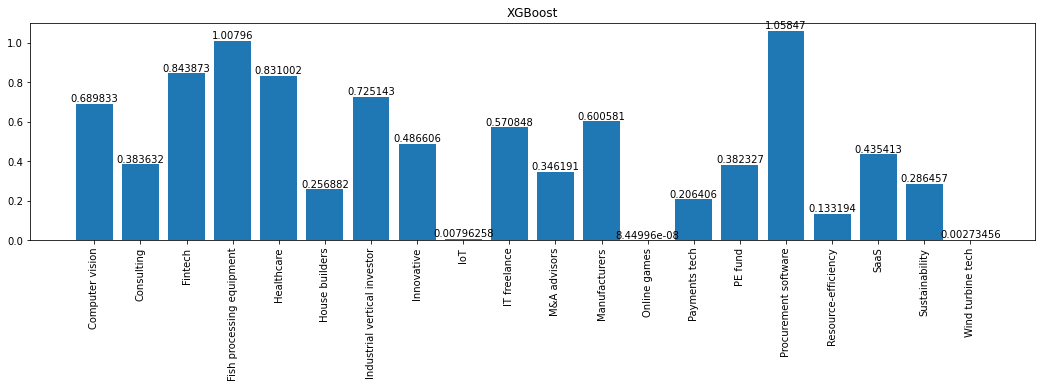

In [32]:
_, _ = plot_accuracies(accuracies, "XGBoost")
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Train one file, test on all others individually

#### Logistic

In [42]:

dfcs = {}
accuracies = [[] for _ in range(len(file_names))]

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    X_train, y_train = dfcs[train_file].get_tfidf_vectors(split=False)
    clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)

    for test_file in file_names:
        X_test, y_test = dfcs[test_file].get_tfidf_vectors(split=False)
        accuracies[i].append(clf.score(X_test,y_test))

100%|██████████| 20/20 [00:00<00:00, 25.19it/s]
20it [00:00, 147.82it/s]


In [43]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [44]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc)

Average accuracy: 0.5118751763380222
---
{'Computer vision': 0.4674723781201936, 'Consulting': 0.5420192426998806, 'Fintech': 0.4654156876268408, 'Fish processing equipment': 0.4637778587493949, 'Healthcare': 0.4596474239667863, 'House builders': 0.5638898709151661, 'Industrial vertical investor': 0.4789593076506849, 'Innovative': 0.4620186567001345, 'IoT': 0.5420192426998806, 'IT freelance': 0.4701055626869647, 'M&A advisors': 0.48850165222091846, 'Manufacturers': 0.5388991852064403, 'Online games': 0.5420192426998806, 'Payments tech': 0.5570913733449366, 'PE fund': 0.5420192426998806, 'Procurement software': 0.45798075730011967, 'Resource-efficiency': 0.5420192426998806, 'SaaS': 0.5528280938309088, 'Sustainability': 0.5420192426998806, 'Wind turbine tech': 0.5588002622416676}


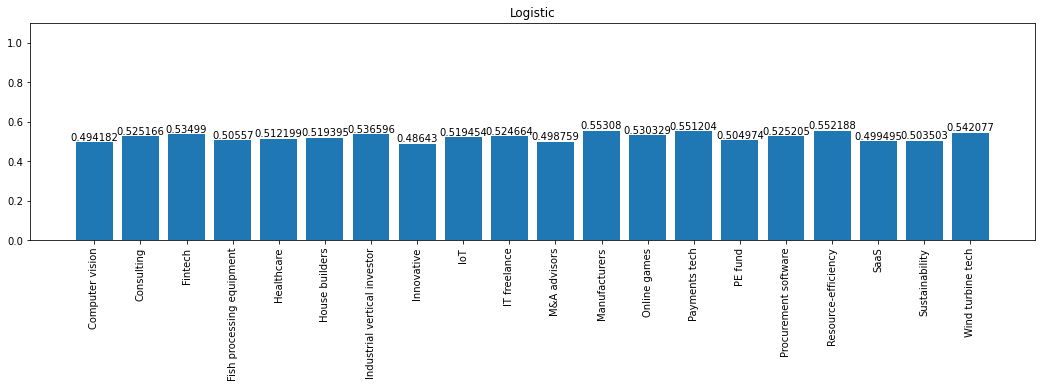

In [41]:
_,_ = plot_accuracies(acc, "Logistic")
plt.show()

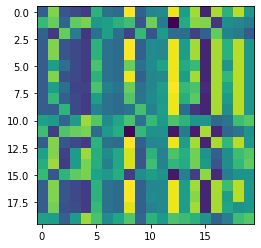

In [37]:
plt.imshow(accuracies)

#### XGBoost

In [88]:
dfcs = {}
accuracies = [[] for _ in range(len(file_names))]
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')#, colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    X_train, y_train = dfcs[train_file].get_feature_vectors(split=False)

    for test_file in file_names:
        X_test, y_test = dfcs[test_file].get_feature_vectors(split=False)
        
        xg_reg.fit(X_train, y_train)
        preds = xg_reg.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, preds))
        
        accuracies[i].append(score)

100%|██████████| 20/20 [00:00<00:00, 93.51it/s]
20it [03:42, 11.11s/it]


In [89]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [90]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc)

Average accuracy: 0.5863521695741195
---
{'Computer vision': 0.5666327288986867, 'Consulting': 0.5617434543389521, 'Fintech': 0.6545732811802506, 'Fish processing equipment': 0.6270203141668713, 'Healthcare': 0.5692216719598185, 'House builders': 0.5326905857626879, 'Industrial vertical investor': 0.5781667883885295, 'Innovative': 0.5721678205000682, 'IoT': 0.6089150731122486, 'IT freelance': 0.5918838513183641, 'M&A advisors': 0.5380501988489267, 'Manufacturers': 0.5877542365856122, 'Online games': 0.6131780868363115, 'Payments tech': 0.5501260038314215, 'PE fund': 0.5839617422906812, 'Procurement software': 0.6203573506368796, 'Resource-efficiency': 0.5383919336957688, 'SaaS': 0.6338232291328937, 'Sustainability': 0.6327981366540881, 'Wind turbine tech': 0.5655869033433286}


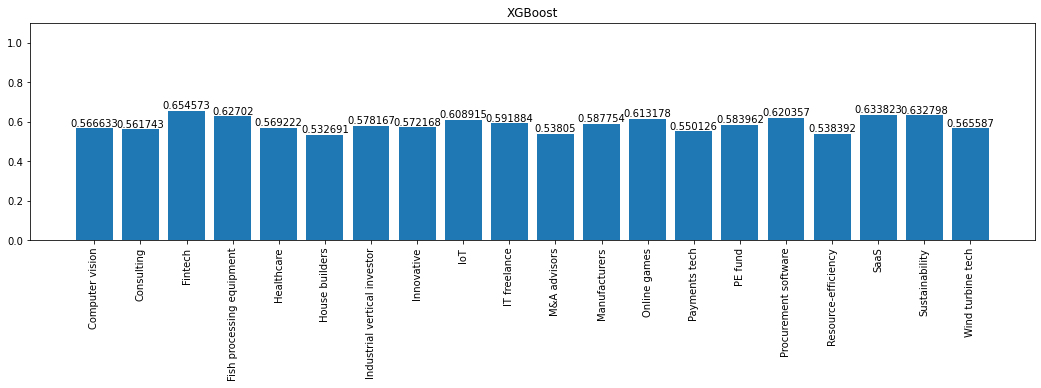

In [91]:
_,_ = plot_accuracies(acc, "XGBoost")
plt.show()

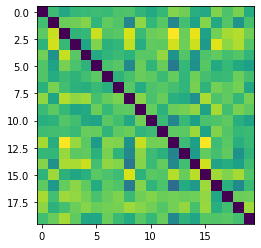

In [92]:
plt.imshow(accuracies)

## Train all files except one, test on the last

#### Logistic

In [62]:
dfcs = {}
accuracies = {}

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for test_file in tqdm(file_names):

    X_train, y_train = [], []
    X_test, y_test = dfcs[test_file].get_tfidf_vectors(split=False)
    
    for train_file in file_names:
        if train_file == test_file:
            continue
        new_X_train, new_y_train = dfcs[train_file].get_tfidf_vectors(split=False)
        X_train.extend(new_X_train)
        y_train.extend(new_y_train)
        
    clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
    accuracies[test_file] = clf.score(X_test, y_test)

100%|██████████| 20/20 [00:00<00:00, 70.96it/s]


In [63]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.5544954744899038
---
{'Computer vision': 0.4868421052631579, 'Consulting': 0.4426229508196721, 'Fintech': 0.6716417910447762, 'Fish processing equipment': 0.4927536231884058, 'Healthcare': 0.6, 'House builders': 0.39285714285714285, 'Industrial vertical investor': 0.5652173913043478, 'Innovative': 0.4605263157894737, 'IoT': 0.5, 'IT freelance': 0.5409836065573771, 'M&A advisors': 0.4642857142857143, 'Manufacturers': 0.5972222222222222, 'Online games': 0.6666666666666666, 'Payments tech': 0.5285714285714286, 'PE fund': 0.47058823529411764, 'Procurement software': 0.5573770491803278, 'Resource-efficiency': 0.6571428571428571, 'SaaS': 0.6181818181818182, 'Sustainability': 0.68, 'Wind turbine tech': 0.6964285714285714}


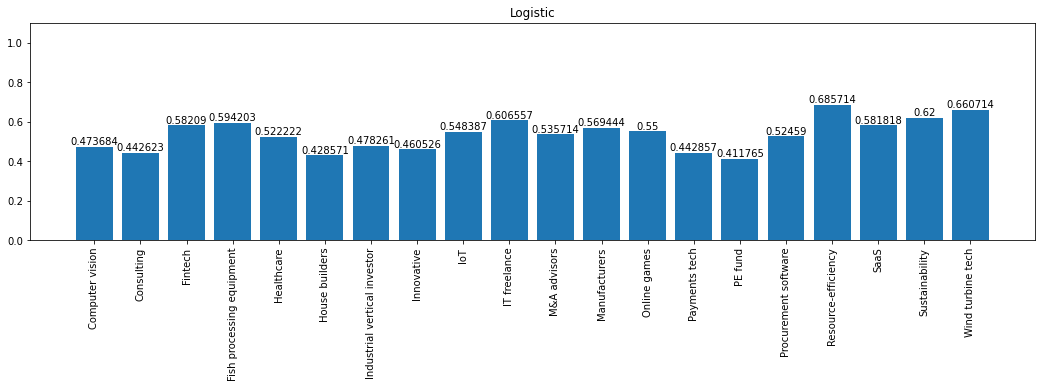

In [48]:
_,_ = plot_accuracies(accuracies, "Logistic")
plt.show()

#### XGBoost

In [96]:
dfcs = {}
accuracies = {}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for test_file in tqdm(file_names):

    X_train, y_train = [], []
    X_test, y_test = dfcs[test_file].get_feature_vectors(split=False)
    
    for train_file in file_names:
        if train_file == test_file:
            continue
        new_X_train, new_y_train = dfcs[train_file].get_feature_vectors(split=False)
        X_train.extend(new_X_train)
        y_train.extend(new_y_train)
        
    
    xg_reg.fit(X_train, y_train)
    preds = xg_reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, preds))
    
    accuracies[test_file] = score

100%|██████████| 20/20 [03:17<00:00,  9.89s/it]


In [97]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.5465978642541649
---
{'Computer vision': 0.548190316927572, 'Consulting': 0.41840956473518925, 'Fintech': 0.6108258305478755, 'Fish processing equipment': 0.5064315555251498, 'Healthcare': 0.5825461715070437, 'House builders': 0.5190802430878693, 'Industrial vertical investor': 0.5714688166583541, 'Innovative': 0.5192277340450587, 'IoT': 0.4714545522688264, 'IT freelance': 0.591736473377535, 'M&A advisors': 0.5039259442738117, 'Manufacturers': 0.6031444148289897, 'Online games': 0.5103487021497777, 'Payments tech': 0.5865123797786015, 'PE fund': 0.5174380865833266, 'Procurement software': 0.5443703808178287, 'Resource-efficiency': 0.6080774815194273, 'SaaS': 0.6406562604502892, 'Sustainability': 0.4757208134680511, 'Wind turbine tech': 0.6023915625327213}


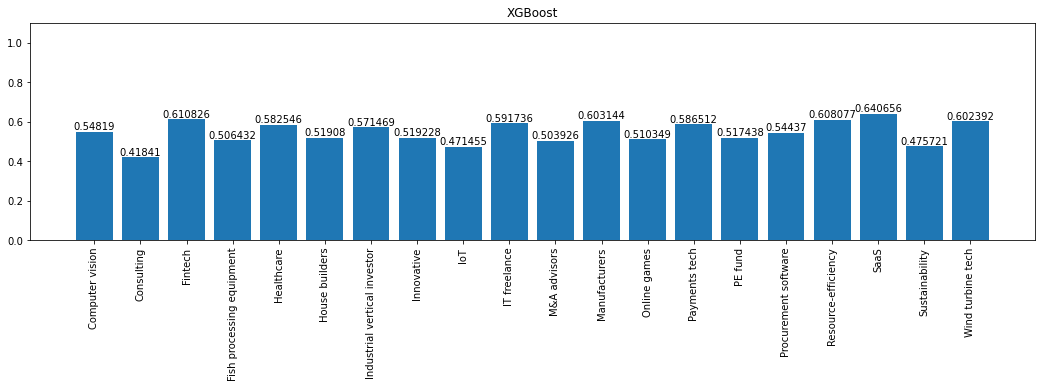

In [98]:
_,_ = plot_accuracies(accuracies, "XGBoost")
plt.show()

# Crossvalidation 

## XGBoost

### Train

In [ ]:

dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train, y_train = dfc.get_feature_vectors(split=False)

dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test, y_test = dfc.get_feature_vectors(split=False)

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
clf = GridSearchCV(xgb_model, {
    'booster' : ['gbtree', 'gblinear', 'dart'],
    'n_estimators' : [1, 5, 10, 20, 50]
    }, 
    verbose=1,
    n_jobs=2
)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
-0.28686038591100343
{'booster': 'gblinear', 'n_estimators': 5}


### Test

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, preds))
score

0.6378804294309922